In [4]:
import xarray as xr

from pydantic import BaseModel, constr, field_validator, ValidationInfo, model_validator
from datetime import datetime
from typing import List, Any, Optional
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
class HydCal(BaseModel):
    refdes: constr(min_length=27, max_length=27)
    deployment: str
    asset_id: constr(min_length=17, max_length=17)
    model: str
    sn: int
    cal_date: datetime
    frequencies: List[float]
    sens: List[float] = None
    sens0: List[float] = None
    sens90: List[float] = None
    ds: Any = None
    rca_bb_offset: float = 128.9  #NOTE OOI broadband hydrophone output is 24-bit ADC with maximum 3 volts. 
    # So, there are 8388608 / 3 = 2796202 counts per volt which is equivalent to 128.9 dB (=20log10(2796202)).

    @model_validator(mode="after")
    def convert_date(self):
        """Convert cal_date to an ISO 8601 string immediately after instantiation."""
        self.cal_date = self.cal_date.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
        return self  # Must return self in a model validator

    @field_validator("frequencies", mode="before")
    @classmethod
    def convert_freqs(cls, values):
        """Convert kHz to Hz by multiplying each element by 1000."""
        return [v * 1000 for v in values]

    @field_validator("sens")
    @classmethod
    def check_lengths(cls, v, info):
        if "frequencies" in info.data and len(v) != len(info.data["frequencies"]):
            raise ValueError("sens and frequencies must be the same length")
        return v

    def make_ndarray(self):
        if self.sens is not None:
            print("creating only a single sensitivity data var")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity": (["frequency"], self.sens),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "asset_id": self.asset_id,
                "model": self.model,
                "serial_number": self.sn,
                "calibration_date": self.cal_date,
            }
            )
        elif self.sens0 is not None and self.sens90 is not None:
            print("creating both 0 and 90 degree sensitivities")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity_0": (["frequency"], self.sens0),
                "sensitivity_90": (["frequency"], self.sens90),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "asset_id": self.asset_id,
                "model": self.model,
                "serial_number": self.sn,
                "calibration_date": self.cal_date,
            }
            )
            

    def save_cal(self):
        self.ds.to_netcdf(f"../metadata/cals/{refdes}_{deployment}.nc", mode="w")

    def save_correction_cal(self):
        if self.sens is not None:
            self.ds["sensitivity"] = self.ds["sensitivity"] + self.rca_bb_offset 
        elif self.sens0 is not None and self.sens90 is not None:
            self.ds["sensitivity"] = (self.ds["sensitivity_0"] + self.ds["sensitivity_90"]) / 2
            self.ds["sensitivity"] = self.ds["sensitivity"] + self.rca_bb_offset 

        self.ds.to_netcdf(f"../metadata/rca_correction_cals/{refdes}_{deployment}.nc", mode="w")
        
        

In [6]:
refdes = "RS03AXPS-PC03A-08-HYDBBA303"
deployment = "11"

In [ ]:
# As of 2025/09 LLMs are quite good at generating the below output from a PDF with some human supervision to 
# confirm the frequency and sensitivity values don't have hallucinations.

In [7]:
asset_id = "ATAPL-58324-00009"
model = "SB35-ETH"
sn = 1362
cal_date = datetime(2023, 3, 8)

frequency = [
    0.0,
    10.0,
    20.1,
    30.1,
    40.2,
    50.2,
    60.2,
    70.3,
    80.3,
    90.4,
    100.4,
    110.4,
    120.5,
    130.5,
    140.5,
    150.6,
    160.6,
    170.7,
    180.7,
    190.7,
    200.0,
]

sens0 = [
    -171.2,
    -171.2,
    -172.9,
    -172.9,
    -171.7,
    -171.7,
    -170.6,
    -171.2,
    -173.8,
    -175.0,
    -174.3,
    -174.4,
    -173.4,
    -171.3,
    -170.4,
    -169.3,
    -169.6,
    -169.8,
    -171.6,
    -173.1,
    -175.9,
]

sens90 = [
    -171.2,
    -171.2,
    -172.6,
    -172.1,
    -171.7,
    -172.7,
    -170.6,
    -171.2,
    -173.5,
    -174.6,
    -173.3,
    -172.2,
    -171.9,
    -171.0,
    -170.3,
    -169.8,
    -170.6,
    -169.4,
    -170.8,
    -172.2,
    -174.2,
]

In [8]:
hyd = HydCal(
    refdes=refdes,
    deployment=deployment,
    asset_id=asset_id,
    model=model,
    sn=sn,
    cal_date=cal_date,
    frequencies = frequency,
    #sens=sens,
    sens0=sens0,
    sens90=sens90,
    )

hyd.make_ndarray()

creating both 0 and 90 degree sensitivities


In [9]:
hyd.cal_date

'2023-03-08T00:00:00.000000Z'

In [10]:
hyd.ds.sensitivity.plot()  # Plot the DataArray

AttributeError: 'Dataset' object has no attribute 'sensitivity'

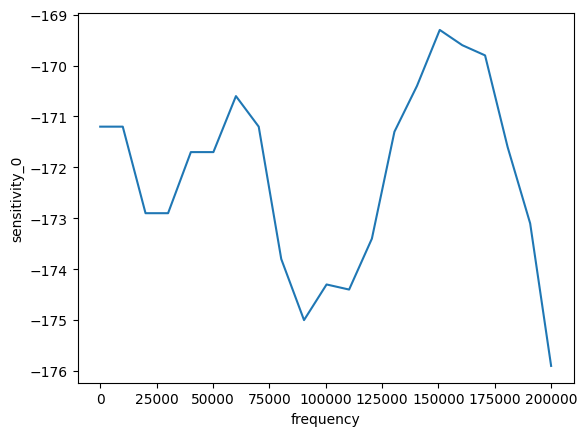

In [11]:
hyd.ds["sensitivity_0"].plot()  # Plot the DataArray

In [12]:
hyd.save_cal()
hyd.save_correction_cal()

In [11]:
test = xr.open_dataset(f"../metadata/rca_correction_cals/{refdes}_{deployment}.nc")

In [12]:
test.sensitivity.values

array([-42.7 , -42.7 , -43.65, -43.55, -42.2 , -43.75, -42.15, -43.6 ,
       -45.2 , -44.3 , -42.95, -42.95, -43.5 , -43.85, -43.  , -41.6 ,
       -40.65, -40.45, -42.15, -44.45, -48.15])

In [13]:
test

<xarray.Dataset>
Dimensions:         (frequency: 21)
Coordinates:
  * frequency       (frequency) float64 0.0 1e+04 2.01e+04 ... 1.907e+05 2e+05
Data variables:
    sensitivity_0   (frequency) float64 ...
    sensitivity_90  (frequency) float64 ...
    sensitivity     (frequency) float64 -42.7 -42.7 -43.65 ... -44.45 -48.15
Attributes:
    asset_id:          ATAPL-58324-00007
    model:             SB35-ETH
    serial_number:     1292
    calibration_date:  2023-03-02T00:00:00.000000Z